In [1]:
import math
from math import cos, sin, log, log10, pi
from decimal import Decimal as D
import numpy as np
from matplotlib import pyplot as plt
pi, math.e

(3.141592653589793, 2.718281828459045)

In [67]:
# setting
mass = 1.0   
T_max = 10.0      # final time
dt = 0.001        # time step
k = 1.0           # force constant
h_const = 1.0     # let h constant be 1
h_bar = 1.054571817e-34
h_planck = 6.62607015e-34
decimal_place = [-1, -10]  # Define the range of decimal place

In [3]:
def const_force(x):
    return 1.0

In [4]:
# Harmonic oscillation
def force(x):
    return -x

### Morse Potential
Morse potential is given as below to serve as approximation for the potential engery.\
$V(r)=D_e(1-e^{-a(r-r_e)})^2,$\
where $D_e=100,$ $a=1,$ and $r_e=1$ in our experiment.\
The force due to Morse potential is $f(r)=-\frac{dV(r)}{dr},$ which is as below\
$f(r)=-2aD_ee^{-a(r-r_e)}(1-e^{-a(r-r_e)}).$\
Energy under Morse Potential\
$E=D_e(1-e^{-a(r-r_e)})^2+\frac{1}{2}mv^2$

In [5]:
# Morse potential
def morse_potential(x, a=1, De=100, re=1):
    g = math.e**(-a * (x - re))
    return De * (1 - g)**2

In [6]:
# force of Morse potential
def morse_force(x, a=1, De=100, re=1):
    g = math.e**(-a * (x - re))
    f = -2 * a * De * g * (1 - g)
    return f

In [7]:
def total_energy_with_morse_potential(x, v, m=1, a=1, De=100, re=1):
    En = morse_potential(x) + 0.5 * m * (v**2)
    return En

In [8]:
def varlet_velocity(t=0.0, x=1.0, v=0.0, dt=0.001, t_final=T_max, force=force):
    # Must ensure it can run single step calculation.
    # That is, when t = t_0, t_final = t_0 + dt, the result must be correct.
    
    x_lst = []
    v_lst = []
    x_lst.append(x)
    v_lst.append(v)
    
    time = D(str(t))
    t_final = D(str(t_final))
    dt_t = D(str(dt))
    
    # Warning 1: never use np.arange to iterate over float steps
    # because sometimes it will abnormaly include stop condition,
    # which is the result that we do not want it happen.
    #
    # Warning 2: even if you add step size to time iteratively,
    # there is still an inherent error, i.e. floating-point approximation
    # error, which is due to the non-exact representation from
    # the binary floating point standard(IEEE-754). The workaround
    # is to use the decimal.Decimal(str(float_number)) in iteration.
    
    while (time < t_final):
        time += dt_t
        f = force(x)
        v = v + f/(2 * mass) * dt
        x = x + v * dt
        f = force(x)
        v = v + f/(2 * mass) * dt
#         print(dt, x, v)
        x_lst.append(x)
        v_lst.append(v)
    return x_lst, v_lst

In [9]:
x_lst, v_lst = varlet_velocity(dt=dt, x=2, force=morse_force)
len(x_lst)

10001

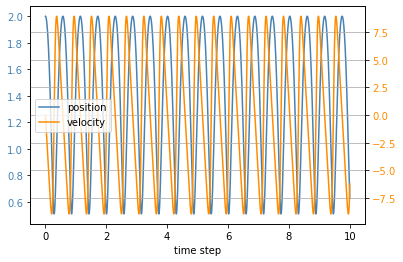

In [10]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('time step')
# ax1.set_ylabel('position', color='b')
pos, = ax1.plot(np.arange(0.0, T_max, dt), x_lst[:-1], label='position', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
vel, = ax2.plot(np.arange(0.0, T_max, dt), v_lst[:-1], label='velocity', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')
plt.legend(handles=[pos, vel])
plt.grid(axis='both')
plt.savefig('xv.png')
plt.show()

### Calculate Period

In [47]:
import time as tt
from datetime import datetime

def asHoursMins(s):
    h = math.floor(s / 3600)
    s -= h * 3600
    m = math.floor(s / 60)
    s -= m * 60
    return '%2dh %2dm %2ds' % (h, m, s)

# For the use of decorator, refer to the following two links:
#
# https://medium.com/citycoddee/python%E9%80%B2%E9%9A%8E%E6%8A%80%E5%B7%A7-3-%E7%A5%9E%E5%A5%87%E5%8F%88%E7%BE%8E%E5%A5%BD%E7%9A%84-decorator-%E5%97%B7%E5%97%9A-6559edc87bc0
# https://dev.to/apcelent/python-decorator-tutorial-with-example-529f

class code_timer:
    def __init__(self, func):
        self.code_func = func
        self.code_name = func.__name__
        
    def __call__(self, *args, **kwargs):
        start_time = datetime.fromtimestamp(tt.time())
        print('Begin running %s at %s ...'%\
              (self.code_name, start_time.strftime("%Y-%m-%d %H:%M:%S")))
        result = self.code_func(*args, **kwargs)
        stop_time = datetime.fromtimestamp(tt.time())
        train_time = (stop_time - start_time).total_seconds()
        print('Done running at %s!'%\
              (stop_time.strftime("%Y-%m-%d %H:%M:%S")))
        print('Total running time : %s'%(asHoursMins(train_time)))
        return result

In [53]:
@code_timer
def calculate_period(t=0.0, x=2.0, v=0.0, dt=0.001, t_final=T_max, force=morse_force):
    x_lst = []
    x_lst.append(x)
    
    begin_time = 0
    end_time = 0
    counter = 0
    period = 0
    
    time = D(str(t))
    t_final = D(str(t_final))
    dt_t = D(str(dt))
    
    while (time < t_final):
        x_old, v_old = x, v
        x_l, v_l = varlet_velocity(t=time, x=x_old, v=v_old, dt=dt,\
                                   t_final=time+dt_t,\
                                   force=force)
        x, v = x_l[-1], v_l[-1]
#         x_lst.append(x)      # don't keep it to save space and time
        time += dt_t
        if ((1 - x) * (1 - x_old) <= 0):
            print('<=0', 'counter =', counter, 'x_old =', x_old, 't_old =', time - dt_t, 'x_new =', x)
            if counter == 0:
                begin_time = time - dt_t + D(str((1 - x_old) / ((x - x_old) / dt)))
                counter += 1
                print('begin time =', begin_time)
            elif counter == 1:
                counter += 1
            elif counter == 2:
                end_time = time - dt_t + D(str((1 - x_old) / ((x - x_old) / dt)))
                period = end_time - begin_time
                print('end time =', end_time)
                break
    
    print('counter =', counter)    
    return period, x_lst

In [57]:
v0 = (2 * compute_En(q_num=1))**0.5
ppp, xxx = calculate_period(x=1, v=v0, dt=1e-9)

Begin running calculate_period at 2020-12-02 11:59:20 ...
<=0 counter = 0 x_old = 1 t_old = 0E-9 x_new = 1.0000000063384862
begin time = 0E-9
<=0 counter = 1 x_old = 1.00000000318064 t_old = 0.322025586 x_new = 0.9999999968421538
<=0 counter = 2 x_old = 0.9999999956442682 t_old = 0.497003472 x_new = 1.0000000019827544
end time = 0.497003472687188021132485
counter = 2
Done running at 2020-12-02 12:19:29!
Total running time :  0h 20m  9s


In [58]:
period_of_quantum_number_1eM9 = {}
period_of_quantum_number_1eM9[1] = ppp

0.497003472687188021132485


In [62]:
period_of_quantum_number_1eM9

{1: Decimal('0.497003472687188021132485'),
 2: Decimal('0.53969353306413868365554972'),
 3: Decimal('0.5904064305628663630249701'),
 4: Decimal('0.6516383457323439351094017'),
 5: Decimal('0.7270408126797660150851513')}

In [64]:
err_delta_T = {1: [0.07261608778345201,
  0.00033126532478508307,
  3.2597025237013363e-06,
  3.259579995362997e-08,
  3.2597472759873143e-10,
  3.251233019466173e-12,
  5.830305528054355e-14,
  5.104309628967127e-14],
 2: [0.025901640164419024,
  0.00010614633150532041,
  1.0613045229274234e-06,
  1.0659242185510508e-08,
  1.0663103018455435e-10,
  1.046465110338881e-12,
  3.908558501364014e-15,
  2.242278298150934e-14],
 3: [0.05827009821477998,
  0.0006563717303392074,
  6.497353076450157e-06,
  6.494790198139011e-08,
  6.494500779838542e-10,
  6.497291350677974e-12,
  8.65001742681138e-15,
  3.5502680221347577e-13],
 4: [0.24597765327606694,
  0.001363506447331469,
  1.3502617064958728e-05,
  1.3505498415872842e-07,
  1.3505160342528603e-09,
  1.356978664950678e-11,
  3.298442747805332e-13,
  1.3629928709939388e-14],
 5: [0.41535080373191363,
  0.002299335125926901,
  2.2875687040409e-05,
  2.2872119027892012e-07,
  2.2871706390168677e-09,
  2.2868088823865026e-11,
  1.0536600884428375e-14,
  5.677548128739811e-13]}
err_delta_T

{1: [0.07261608778345201,
  0.00033126532478508307,
  3.2597025237013363e-06,
  3.259579995362997e-08,
  3.2597472759873143e-10,
  3.251233019466173e-12,
  5.830305528054355e-14,
  5.104309628967127e-14],
 2: [0.025901640164419024,
  0.00010614633150532041,
  1.0613045229274234e-06,
  1.0659242185510508e-08,
  1.0663103018455435e-10,
  1.046465110338881e-12,
  3.908558501364014e-15,
  2.242278298150934e-14],
 3: [0.05827009821477998,
  0.0006563717303392074,
  6.497353076450157e-06,
  6.494790198139011e-08,
  6.494500779838542e-10,
  6.497291350677974e-12,
  8.65001742681138e-15,
  3.5502680221347577e-13],
 4: [0.24597765327606694,
  0.001363506447331469,
  1.3502617064958728e-05,
  1.3505498415872842e-07,
  1.3505160342528603e-09,
  1.356978664950678e-11,
  3.298442747805332e-13,
  1.3629928709939388e-14],
 5: [0.41535080373191363,
  0.002299335125926901,
  2.2875687040409e-05,
  2.2872119027892012e-07,
  2.2871706390168677e-09,
  2.2868088823865026e-11,
  1.0536600884428375e-14,
  5.

In [66]:
for q_n in range(1, 6):
    delta_En = compute_delta_En(q_num=q_n)
    period_th = (2 * pi) / delta_En      # theoretical period
    print('theoretical period =', period_th)
    error = abs((float(period_of_quantum_number_1eM9[q_n]) - period_th) / period_th)
    err_delta_T[q_n].append(error)

err_delta_T

theoretical period = 0.4970034726874169
theoretical period = 0.539693533063826
theoretical period = 0.5904064305634933
theoretical period = 0.6516383457328259
theoretical period = 0.7270408126813257


{1: [0.07261608778345201,
  0.00033126532478508307,
  3.2597025237013363e-06,
  3.259579995362997e-08,
  3.2597472759873143e-10,
  3.251233019466173e-12,
  5.830305528054355e-14,
  5.104309628967127e-14,
  4.60504783374868e-13],
 2: [0.025901640164419024,
  0.00010614633150532041,
  1.0613045229274234e-06,
  1.0659242185510508e-08,
  1.0663103018455435e-10,
  1.046465110338881e-12,
  3.908558501364014e-15,
  2.242278298150934e-14,
  5.794952262285488e-13],
 3: [0.05827009821477998,
  0.0006563717303392074,
  6.497353076450157e-06,
  6.494790198139011e-08,
  6.494500779838542e-10,
  6.497291350677974e-12,
  8.65001742681138e-15,
  3.5502680221347577e-13,
  1.0618836610696492e-12],
 4: [0.24597765327606694,
  0.001363506447331469,
  1.3502617064958728e-05,
  1.3505498415872842e-07,
  1.3505160342528603e-09,
  1.356978664950678e-11,
  3.298442747805332e-13,
  1.3629928709939388e-14,
  7.395940066230861e-13],
 5: [0.41535080373191363,
  0.002299335125926901,
  2.2875687040409e-05,
  2.2872

In [61]:
for _ in range(2,6):
    print('quantum number =', _)
    v0 = (2 * compute_En(q_num=_))**0.5
    ppp, xxx = calculate_period(x=1, v=v0, dt=1e-9)
    period_of_quantum_number_1eM9[_] = ppp
    print('----')

quantum number = 2
Begin running calculate_period at 2020-12-02 12:33:25 ...
<=0 counter = 0 x_old = 1 t_old = 0E-9 x_new = 1.0000000080287408
begin time = 0E-9
<=0 counter = 1 x_old = 1.0000000004447789 t_old = 0.373561553 x_new = 0.9999999924160381
<=0 counter = 2 x_old = 0.9999999994850471 t_old = 0.539693533 x_new = 1.0000000075137878
end time = 0.53969353306413868365554972
counter = 2
Done running at 2020-12-02 12:55:14!
Total running time :  0h 21m 48s
----
quantum number = 3
Begin running calculate_period at 2020-12-02 12:55:14 ...
<=0 counter = 0 x_old = 1 t_old = 0E-9 x_new = 1.000000009313697
begin time = 0E-9
<=0 counter = 1 x_old = 1.0000000069324149 t_old = 0.430312804 x_new = 0.999999997618718
<=0 counter = 2 x_old = 0.9999999947576333 t_old = 0.590406430 x_new = 1.0000000040713302
end time = 0.5904064305628663630249701
counter = 2
Done running at 2020-12-02 13:19:10!
Total running time :  0h 23m 56s
----
quantum number = 4
Begin running calculate_period at 2020-12-02 13:

In [ ]:
period_time, x_ll = calculate_period(force=morse_force)
print(period_time, 2*pi)

In [ ]:
period_time_01, x_ll_01 = calculate_period(dt=0.01, force=morse_force)
print(period_time_01, len(x_ll_01))

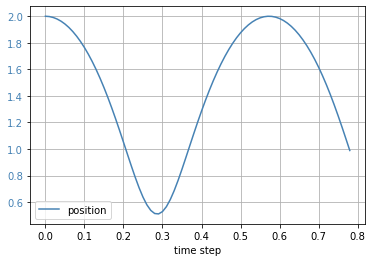

In [15]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('time step')
# ax1.set_ylabel('position', color='b')
pos, = ax1.plot(np.arange(0.0, 0.79, 0.01), x_ll_01, label='position', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

# ax2 = ax1.twinx()
# vel, = ax2.plot(np.arange(0.0, T_max, dt), v_lst[:-1], label='velocity', color='darkorange')
# ax2.tick_params(axis='y', labelcolor='darkorange')
plt.legend(handles=[pos, ])
plt.grid(axis='both')
plt.savefig('x_dt_01.png')
plt.show()

### Verify $\Delta E_n\Delta T=2\pi\hbar$

In [20]:
(2 * pi * h_const) / compute_delta_En(q_num=1)

0.4970034726874169

In [17]:
def compute_En(q_num, a=1, De=100, re=1):
    omega = a*(2*De/mass)**0.5
    En = h_const * omega * (q_num + 1/2) - (1/(4 * De)) * (h_const * omega * (q_num + 1/2))**2
    return En

In [19]:
# Use this function to compute delta En
def compute_delta_En(q_num, a=1, De=100, re=1):
    omega = a*(2*De/mass)**0.5
    delta_E = h_const * omega - (1 / (4 * De)) * ((h_const * omega)**2) * (2 * q_num + 1)
    return delta_E

In [21]:
exponent = list(range(decimal_place[0], decimal_place[1], -1))
exponent

[-1, -2, -3, -4, -5, -6, -7, -8]

In [22]:
# compute period with quantum number = 1, 2, 3,...
def compute_period_with_q_num(t=0.0, x=2.0, v=0.0, dt=0.001, t_final=T_max, force=morse_force):
    exponent = list(range(decimal_place[0], decimal_place[1], -1))
    error_dict = {}
    K = 2 * pi * h_const
    
    for q_n in range(1, 6):
        print('quantum number = ', q_n)
        error_list = []
        En = compute_En(q_num=q_n)
        delta_En = compute_delta_En(q_num=q_n)
        period_th = K / delta_En      # theoretical period
        print('theoretical period =', period_th)
        v0 = (2 * En)**0.5
        for _ in exponent:
            dt_ = 10**(_)
            period, x_ll = calculate_period(x=1.0, v=v0, dt=dt_, force=force)
            print(dt_, period)
            error = abs((float(period) - period_th) / period_th)
            error_list.append(error)
        print('---')
        error_dict[q_n] = error_list
    return error_dict

In [21]:
err_delta_T = compute_period_with_q_num()
err_delta_T

quantum number =  1
theoretical period = 0.4970034726874169
0.1 0.46091302488606693
0.01 0.496838832670617799
0.001 0.4970018526039426764403
0.0001 0.497003456487191136845
1e-05 0.4970034725254063089814
1e-06 0.49700347268580100378544
1e-07 0.49700347268744585843553
1e-08 0.4970034726874422867993793
---
quantum number =  2
theoretical period = 0.539693533063826
0.1 0.5257145853713427
0.01 0.539750819552497795
0.001 0.5396941058430136151
0.0001 0.53969353881654998503
1e-05 0.539693533121373992369
1e-06 0.539693533064390696363
1e-07 0.539693533063823848061216
1e-08 0.5396935330638138827903316
---
quantum number =  3
theoretical period = 0.5904064305634933
0.1 0.624809471259065696
0.01 0.5907939566539255967
0.001 0.5904102666425313033
0.0001 0.5904064689091522300535
1e-05 0.590406430946932744452
1e-06 0.59040643056732934675795
1e-07 0.59040643056348813943523
1e-08 0.5904064305637029407375011
---
quantum number =  4
theoretical period = 0.6516383457328259
0.1 0.811926816800884723
0.01 0.65

{1: [0.07261608778345201,
  0.00033126532478508307,
  3.2597025237013363e-06,
  3.259579995362997e-08,
  3.2597472759873143e-10,
  3.251233019466173e-12,
  5.830305528054355e-14,
  5.104309628967127e-14],
 2: [0.025901640164419024,
  0.00010614633150532041,
  1.0613045229274234e-06,
  1.0659242185510508e-08,
  1.0663103018455435e-10,
  1.046465110338881e-12,
  3.908558501364014e-15,
  2.242278298150934e-14],
 3: [0.05827009821477998,
  0.0006563717303392074,
  6.497353076450157e-06,
  6.494790198139011e-08,
  6.494500779838542e-10,
  6.497291350677974e-12,
  8.65001742681138e-15,
  3.5502680221347577e-13],
 4: [0.24597765327606694,
  0.001363506447331469,
  1.3502617064958728e-05,
  1.3505498415872842e-07,
  1.3505160342528603e-09,
  1.356978664950678e-11,
  3.298442747805332e-13,
  1.3629928709939388e-14],
 5: [0.41535080373191363,
  0.002299335125926901,
  2.2875687040409e-05,
  2.2872119027892012e-07,
  2.2871706390168677e-09,
  2.2868088823865026e-11,
  1.0536600884428375e-14,
  5.

In [20]:
dd = 1e-10
print('0.12345678901234567890123456789012345678901234567890')
print(D(dd))
print(0.00000000000123)

0.12345678901234567890123456789012345678901234567890
1.0000000000000000364321973154977415791655470655996396089904010295867919921875E-10
1.23e-12


#### Plot  $\left|\frac{\Delta \widetilde{T}-\Delta T}{\Delta T}\right|$ with Quantum Number $n=1,2,\ldots,5$

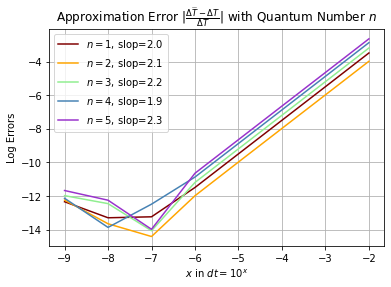

In [68]:
def get_slop(err_list):
    x_big = -1
    x_small = 0 - len(err_list) + 2
    slop = (err_list[x_big] - err_list[x_small]) / (x_big - x_small)
    return slop

new_e = list(range(decimal_place[0]-1, decimal_place[1], -1))[::-1]

new_delta_energy_1 = [log10(_) for _ in err_delta_T[1][1:]][::-1]
new_delta_energy_2 = [log10(_) for _ in err_delta_T[2][1:]][::-1]
new_delta_energy_3 = [log10(_) for _ in err_delta_T[3][1:]][::-1]
new_delta_energy_4 = [log10(_) for _ in err_delta_T[4][1:]][::-1]
new_delta_energy_5 = [log10(_) for _ in err_delta_T[5][1:]][::-1]

slop_delta_engy_1 = get_slop(new_delta_energy_1)
slop_delta_engy_2 = get_slop(new_delta_energy_2)
slop_delta_engy_3 = get_slop(new_delta_energy_3)
slop_delta_engy_4 = get_slop(new_delta_energy_4)
slop_delta_engy_5 = get_slop(new_delta_energy_5)

color_list = ['', 'maroon', 'orange', 'lightgreen', 'steelblue', 'darkorchid']

delta_engy_1, = plt.plot(new_e, new_delta_energy_1, color=color_list[1], label=r'$n=1$, slop=%1.1f'%slop_delta_engy_1)
delta_engy_2, = plt.plot(new_e, new_delta_energy_2, color=color_list[2], label=r'$n=2$, slop=%1.1f'%slop_delta_engy_2) 
delta_engy_3, = plt.plot(new_e, new_delta_energy_3, color=color_list[3], label=r'$n=3$, slop=%1.1f'%slop_delta_engy_3) 
delta_engy_4, = plt.plot(new_e, new_delta_energy_4, color=color_list[4], label=r'$n=4$, slop=%1.1f'%slop_delta_engy_4) 
delta_engy_5, = plt.plot(new_e, new_delta_energy_5, color=color_list[5], label=r'$n=5$, slop=%1.1f'%slop_delta_engy_5) 

plt.legend(handles=[delta_engy_1, delta_engy_2, delta_engy_3, delta_engy_4, delta_engy_5])
# text_x = min(new_e) + (max(new_e) - min(new_e)) * 0.35
# text_y_1 = (max(new_delta_energy) - min(new_delta_energy)) * 0.90 + min(new_delta_energy)
# plt.text(text_x, text_y_1, r'Slop=%1.1f'%slop_delta_engy)
plt.title(r'Approximation Error $\left|\frac{\Delta \widetilde{T}-\Delta T}{\Delta T}\right|$ with Quantum Number $n$')
plt.xlabel(r'$x$ in $dt=10^{x}$')
plt.ylabel('Log Errors')
plt.grid()
plt.savefig('delta_T_q_n.png')
plt.show()
plt.close()

In [13]:
def calculate_delta_T_with_different_dt(t=0.0, x=2.0, v=0.0, dt=0.001, t_final=T_max, force=morse_force):
    exponent = list(range(decimal_place[0], decimal_place[1], -1))
    error_list = []
    K = 2 * pi * h_const
    print('K =',K)
    delta_En = compute_delta_En_1(x=x)
    period_th = K / delta_En
    for _ in exponent:
        dt_ = 10**(_)
        period, x_ll = calculate_period(dt=dt_, force=force)
        print(dt_, period)
        error = abs((float(period) - period_th) / period_th)
        error_list.append(error)
    return error_list

In [ ]:
err_delta_ET = calculate_delta_ET_with_different_dt()
err_delta_ET

In [ ]:
err_delta_ET = calculate_delta_T_with_different_dt()
err_delta_ET

#### Plot  $\left|\frac{\Delta \widetilde{T}-\Delta T}{\Delta T}\right|$ with Different $dt$

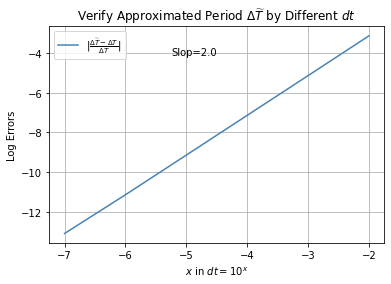

In [262]:
new_e = list(range(decimal_place[0]-1, decimal_place[1], -1))[::-1]
new_delta_energy = [log10(_) for _ in err_delta_ET[1:]][::-1]
delta_engy, = plt.plot(new_e, new_delta_energy, color='steelblue', label=r'$\left|\frac{\Delta \widetilde{T}-\Delta T}{\Delta T}\right|$')

x_big = -1
x_small = 0 - len(new_delta_energy)
slop_delta_engy = (new_delta_energy[x_big] - new_delta_energy[x_small])/(x_big - x_small)

plt.legend(handles=[delta_engy])
text_x = min(new_e) + (max(new_e) - min(new_e)) * 0.35
text_y_1 = (max(new_delta_energy) - min(new_delta_energy)) * 0.90 + min(new_delta_energy)
plt.text(text_x, text_y_1, r'Slop=%1.1f'%slop_delta_engy)
plt.title(r'Verify Approximated Period $\Delta \widetilde{T}$ by Different $dt$')
plt.xlabel(r'$x$ in $dt=10^{x}$')
plt.ylabel('Log Errors')
plt.grid()
plt.savefig('delta_ET.png')
plt.show()
plt.close()

### Quantum Number Is Integer Starting From $0$
#### If it is not integer, it does not comply with quantum mechanics.
#### So starting to try it from $n=1,2,\ldots$
#### Also let $h=1$

In [16]:
def compute_quantum_number(x, a=1, De=100, re=1):
    omega = a*(2*De/mass)**0.5
    En = morse_potential(x)  # initial position x = 2, v = 0, so no kinetic energy
    A = 2 / (h_bar * omega)
    quantum_number = A * (De - (De**2 - \
                                De * En)**0.5) - 0.5
    return quantum_number

### Compute $\Delta E_n$

In [180]:
# We don't need to compute quantum number as we have further reduced
# average energy spacing by plugging the quantum number equation and 
# have obtained this reduced form.

def compute_delta_En_1(x=1, a=1, De=100, re=1):
    omega = a*(2*De/mass)**0.5
    En = morse_potential(x)
    delta_E = (h_bar * omega / De) * (De**2 - De * En)**0.5
    return delta_E

In [168]:
delta_En = compute_delta_En(compute_quantum_number(2))
delta_En * float(period_time), 2 * pi * h_bar

(6.626022456722363e-34, 6.62607014594008e-34)

In [181]:
delta_En_1 = compute_delta_En_1(x=2)
delta_En_1 * float(period_time)

6.626022456722363e-34

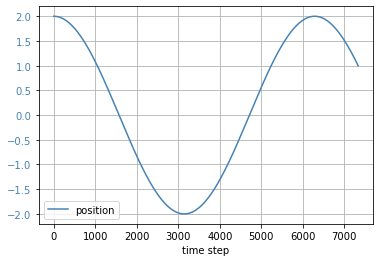

In [95]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('time step')
# ax1.set_ylabel('position', color='b')
pos, = ax1.plot(range(len(x_ll)), x_ll, label='position', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

# ax2 = ax1.twinx()
# vel, = ax2.plot(np.arange(0.0, T_max, dt), v_lst[:-1], label='velocity', color='darkorange')
# ax2.tick_params(axis='y', labelcolor='darkorange')
plt.legend(handles=[pos, ])
plt.grid(axis='both')
plt.savefig('xv.png')
plt.show()

### Total Energy

In [ ]:
def total_energy(t=0.0, x=2.0, v=0.0, dt=0.001, t_final=T_max):    
    e_lst = []
    
    engy = total_energy_with_morse_potential(x, v)
    e_lst.append(engy)
    
    time = D(str(t))
    t_final = D(str(t_final))
    dt_t = D(str(dt))
    
    while (time < t_final):
        x_lst, v_lst = varlet_velocity(t=time, x=x, v=v,\
                                       dt=dt, t_final=time+dt_t,\
                                       force=morse_force)
        x, v = x_lst[-1], v_lst[-1]
        engy = total_energy_with_morse_potential(x, v)
        e_lst.append(engy)
        time += dt_t
    return e_lst    

In [ ]:
e_lst = total_energy()
len(e_lst)

In [ ]:
sum(e_lst)/len(e_lst)

In [ ]:
e_lst_2 = total_energy(dt=0.0001)
len(e_lst_2)

In [ ]:
sum(e_lst_2)/len(e_lst_2)

### Plot Total Energy

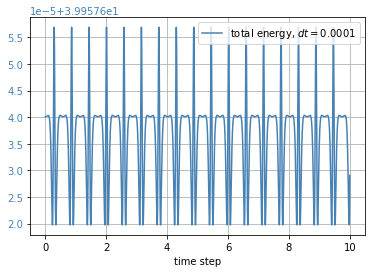

In [102]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('time step')
# ax1.set_ylabel('total energy', color='b')
egy, = ax1.plot(np.arange(0.0, T_max, 0.0001), e_lst_2[:-1], label='total energy, $dt=0.0001$', color='steelblue')
# egy, = ax1.plot(np.arange(0.0, T_max, dt), e_lst[:-1], label='total energy, $dt=0.001$', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

plt.legend(handles=[egy])
plt.grid(axis='both')
plt.savefig('total_energy_dt_1e-4.png')
plt.show()

### Total Energy Error (Compare against initial energy)

In [ ]:
def total_energy_error(t=0.0, x=2.0, v=0.0, dt=0.001, t_final=T_max):    
    e_err_lst = []
    
    engy_0 = total_energy_with_morse_potential(x, v)
    
    time = D(str(t))
    t_final = D(str(t_final))
    dt_t = D(str(dt))
    
    while (time < t_final):
        x_lst, v_lst = varlet_velocity(t=time, x=x, v=v,\
                                       dt=dt, t_final=time+dt_t,\
                                       force=morse_force)
        x, v = x_lst[-1], v_lst[-1]
        engy = total_energy_with_morse_potential(x, v)
        e_err = abs((engy - engy_0)/engy_0)
        e_err_lst.append(e_err)
        time += dt_t
    return e_err_lst    

In [ ]:
e_err_list = total_energy_error()

In [ ]:
e_err_list_2 = total_energy_error(dt=0.0001)

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('time step')
# ax1.set_ylabel('total energy', color='b')
egy, = ax1.plot(np.arange(0.0, T_max, 0.001),\
                e_err_list, label='total energy error, $dt=0.001$', color='steelblue')
# egy, = ax1.plot(np.arange(0.0, T_max, 0.0001), e_lst_2[:-1], label='total energy, $dt=0.0001$', color='steelblue')
# egy, = ax1.plot(np.arange(0.0, T_max, dt), e_lst[:-1], label='total energy, $dt=0.001$', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

plt.title(r'total energy error, $dt=0.001$')
# plt.legend(handles=[egy])
plt.grid(axis='both')
plt.savefig('total_energy_error_dt_1e-3.png')
plt.show()

### Check Energy Difference $\Delta E$ Under Morse Potential with Different $dt$

#### One Step Delta Energy $\Delta E$

In [ ]:
def compute_one_step_delta_energy(x=2, v=0, init_time=0.0):
    exponent = list(range(decimal_place[0], decimal_place[1], -1))
    delta_energy = []
    for _ in exponent:
        dt = 10**(_)
        E_0 = morse_energy(x, v)    # initial energy
        
        x_l, v_l = varlet_velocity(t=init_time, x=x, v=v,\
                                  dt=dt, t_final=init_time+dt,\
                                  force=morse_force)
        x, v = x_l[-1], v_l[-1]
        
        print(dt, x, v)
        E_1 = morse_energy(x, v)
        delta_E = abs((E_1 - E_0) / E_0)
        delta_energy.append(delta_E)
    return delta_energy

In [ ]:
delta_energy = compute_one_step_delta_energy()
delta_energy

#### Plot One Step Delta Energy $\Delta E$ with Different $dt$

In [ ]:
new_e = list(range(decimal_place[0], decimal_place[1], -1))[::-1]
new_delta_energy = [log10(_) for _ in delta_energy][::-1]
delta_engy, = plt.plot(new_e, new_delta_energy, color='steelblue', label=r'$\Delta E$')

x_big = -1
x_small = -4
slop_delta_engy = (new_delta_energy[x_big] - new_delta_energy[x_small])/(x_big - x_small)

plt.legend(handles=[delta_engy])
text_x = min(new_e) + (max(new_e) - min(new_e)) * 0.35
text_y_1 = (max(new_delta_energy) - min(new_delta_energy)) * 0.90 + min(new_delta_energy)
plt.text(text_x, text_y_1, r'Slop_$\Delta E$=%1.1f'%slop_delta_engy)
plt.title(r'One Step $\Delta E$ by Different $dt$')
plt.xlabel(r'$x$ in $dt=10^{x}$')
plt.ylabel('Log Errors')
plt.grid()
plt.savefig('delta_energy.png')
plt.show()
plt.close()

#### Multi Step Delta Energy $\Delta E$ (This part has not yet been verified)

In [ ]:
def compute_multi_step_delta_energy(x=2, v=0, init_time=0.0, t_final=T_max):
    exponent = list(range(decimal_place[0], decimal_place[1], -1))
    delta_energy = []
    for _ in exponent:
        dt = 10**(_)
        E_0 = morse_energy(x, v)    # initial energy
        
        x_l, v_l = varlet_velocity(t=init_time, x=x, v=v,\
                                  dt=dt, t_final=t_final,\
                                  force=morse_force)
        x, v = x_l[-1], v_l[-1]
        
        print(dt, x, v)
        E_1 = morse_energy(x, v)
        delta_E = abs((E_1 - E_0) / E_0)
        delta_energy.append(delta_E)
    return delta_energy

In [ ]:
mul_delta_e = compute_multi_step_delta_energy(t_final=2)
mul_delta_e

#### Plot Multi Step Delta Energy $\Delta E$ with Different $dt$

In [ ]:
new_e = list(range(decimal_place[0], decimal_place[1], -1))[::-1]
new_delta_energy = [log10(_) for _ in mul_delta_e][::-1]
delta_engy, = plt.plot(new_e, new_delta_energy, color='steelblue', label=r'$\Delta E$')

x_big = -1
x_small = -4
slop_delta_engy = (new_delta_energy[x_big] - new_delta_energy[x_small])/(x_big - x_small)

plt.legend(handles=[delta_engy])
text_x = min(new_e) + (max(new_e) - min(new_e)) * 0.35
text_y_1 = (max(new_delta_energy) - min(new_delta_energy)) * 0.90 + min(new_delta_energy)
plt.text(text_x, text_y_1, r'Slop_$\Delta E$=%1.1f'%slop_delta_engy)
plt.title(r'Multi Step $\Delta E$ by Different $dt$')
plt.xlabel(r'$x$ in $dt=10^{x}$')
plt.ylabel('Log Errors')
plt.grid()
plt.savefig('mul_delta_energy.png')
plt.show()
plt.close()